Ball missing at time: 0.33 sec
Ball missing at time: 0.35 sec
Ball missing at time: 0.37 sec
Ball missing at time: 1.00 sec
Ball missing at time: 1.02 sec
Ball missing at time: 1.03 sec
Ball missing at time: 1.50 sec
Ball missing at time: 1.52 sec
Ball missing at time: 1.53 sec
Ball missing at time: 1.55 sec
Ball missing at time: 1.57 sec
Ball missing at time: 1.67 sec
Ball missing at time: 1.68 sec
Ball missing at time: 1.70 sec
Ball missing at time: 2.33 sec
Ball missing at time: 2.35 sec
Ball missing at time: 2.37 sec
Ball missing at time: 3.00 sec
Ball missing at time: 3.02 sec
Ball missing at time: 3.03 sec
Ball missing at time: 3.67 sec
Ball missing at time: 3.68 sec
Ball missing at time: 3.70 sec
Ball missing at time: 3.72 sec
Ball missing at time: 3.73 sec
Ball missing at time: 4.33 sec
Ball missing at time: 4.35 sec
Ball missing at time: 4.37 sec
Ball missing at time: 5.00 sec
Ball missing at time: 5.02 sec
Ball missing at time: 5.03 sec
Ball missing at time: 5.67 sec
Ball mis

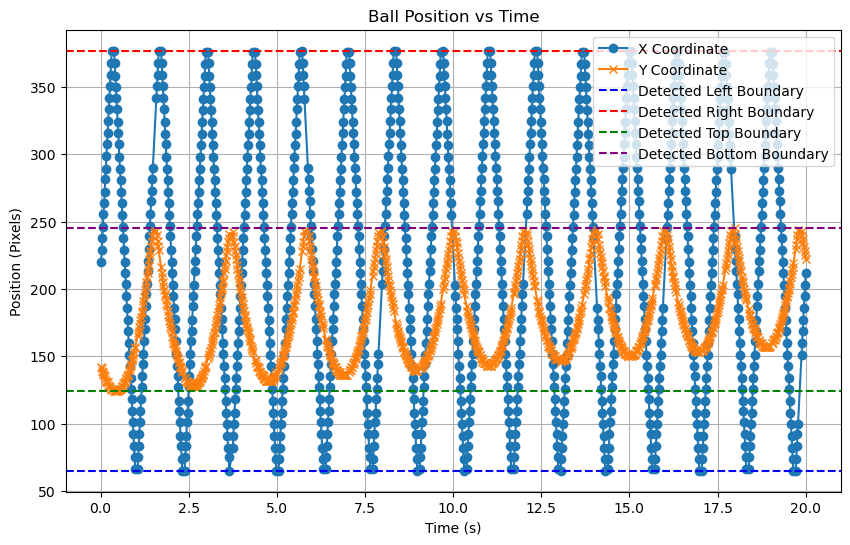

Collision Timestamps:
Boundary: Right, Time (s): 0.32
Boundary: Top, Time (s): 0.32
Boundary: Right, Time (s): 0.38
Boundary: Top, Time (s): 0.38
Boundary: Top, Time (s): 0.40
Boundary: Top, Time (s): 0.42
Boundary: Top, Time (s): 0.43
Boundary: Top, Time (s): 0.45
Boundary: Top, Time (s): 0.47
Boundary: Top, Time (s): 0.48
Boundary: Top, Time (s): 0.50
Boundary: Top, Time (s): 0.52
Boundary: Top, Time (s): 0.53
Boundary: Left, Time (s): 0.98
Boundary: Left, Time (s): 1.05
Boundary: Right, Time (s): 1.65
Boundary: Right, Time (s): 1.72
Boundary: Left, Time (s): 2.32
Boundary: Left, Time (s): 2.38
Boundary: Right, Time (s): 2.98
Boundary: Right, Time (s): 3.05
Boundary: Left, Time (s): 3.65
Boundary: Right, Time (s): 4.32
Boundary: Right, Time (s): 4.38
Boundary: Left, Time (s): 4.98
Boundary: Left, Time (s): 5.05
Boundary: Right, Time (s): 5.65
Boundary: Right, Time (s): 5.72
Boundary: Left, Time (s): 6.32
Boundary: Left, Time (s): 6.38
Boundary: Right, Time (s): 6.98
Boundary: Right, 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize video capture
cap = cv2.VideoCapture('/Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/video_only/video_only_ID_1.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

# Blob Detector Parameters for the Ball
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 20      # Minimum area of the dot
params.maxArea = 500     # Maximum area of the dot
params.filterByCircularity = True
params.minCircularity = 0.8  # Ensures dot is circular
detector = cv2.SimpleBlobDetector_create(params)

# Store data for plotting and analysis
time_data = []
x_data = []
y_data = []

# Process the video frame-by-frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect the Ball using blob detection
    keypoints = detector.detect(gray)
    if not keypoints:
        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
        missing_time = frame_number / fps
        print(f"Ball missing at time: {missing_time:.2f} sec")
    else:
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
            
            # Store coordinates and time for plotting
            time_data.append(frame_number / fps)
            x_data.append(x)
            y_data.append(y)

cap.release()
cv2.destroyAllWindows()

# --- Compute extreme boundaries based on ball tracking data ---
if x_data and y_data:
    detected_left_boundary = min(x_data)
    detected_right_boundary = max(x_data)
    detected_top_boundary = min(y_data)
    detected_bottom_boundary = max(y_data)

    print("Detected boundaries from ball tracking data:")
    print(f"Left boundary: {detected_left_boundary}")
    print(f"Right boundary: {detected_right_boundary}")
    print(f"Top boundary: {detected_top_boundary}")
    print(f"Bottom boundary: {detected_bottom_boundary}")
else:
    print("No ball data was collected.")
    # Exit if no data was collected
    exit()

# --- Detect Collision Timestamps using the detected boundaries ---
# (This step still records collision events per frame)
collision_threshold = 2  # pixels
collision_timestamps = []
for t, x, y in zip(time_data, x_data, y_data):
    if abs(x - detected_left_boundary) < collision_threshold:
        collision_timestamps.append(("Left", t))
    if abs(x - detected_right_boundary) < collision_threshold:
        collision_timestamps.append(("Right", t))
    if abs(y - detected_top_boundary) < collision_threshold:
        collision_timestamps.append(("Top", t))
    if abs(y - detected_bottom_boundary) < collision_threshold:
        collision_timestamps.append(("Bottom", t))

# --- Create a Uniform Collision State Vector ---
# We'll sample at 100 Hz (i.e., 100 samples per second of video)
total_duration = time_data[-1]
sample_rate = 100  # samples per second
num_samples = int(total_duration * sample_rate)
t_uniform = np.linspace(0, total_duration, num=num_samples)

# Interpolate the tracked x and y positions to the uniform time vector
x_uniform = np.interp(t_uniform, time_data, x_data)
y_uniform = np.interp(t_uniform, time_data, y_data)

# Create a binary collision vector:
# A sample is marked as 1 if the ball's interpolated position is within the collision threshold
collision_state = (
    (np.abs(x_uniform - detected_left_boundary) < collision_threshold) |
    (np.abs(x_uniform - detected_right_boundary) < collision_threshold) |
    # (np.abs(y_uniform - detected_top_boundary) < collision_threshold) |
    (np.abs(y_uniform - detected_bottom_boundary) < collision_threshold)
).astype(int)

print("Collision state vector (0: no collision, 1: collision):")
print(collision_state)

# --- Plotting the Ball Position and Detected Boundaries ---
plt.figure(figsize=(10, 6))
plt.plot(time_data, x_data, label='X Coordinate', marker='o')
plt.plot(time_data, y_data, label='Y Coordinate', marker='x')

# Plot lines for the extreme boundaries
plt.axhline(y=detected_left_boundary, color='blue', linestyle='--', label='Detected Left Boundary')
plt.axhline(y=detected_right_boundary, color='red', linestyle='--', label='Detected Right Boundary')
plt.axhline(y=detected_top_boundary, color='green', linestyle='--', label='Detected Top Boundary')
plt.axhline(y=detected_bottom_boundary, color='purple', linestyle='--', label='Detected Bottom Boundary')

plt.xlabel('Time (s)')
plt.ylabel('Position (Pixels)')
plt.title('Ball Position vs Time')
plt.legend()
plt.grid(True)
plt.show()

# --- Print Collision Timestamps (Event-based) ---
print("Collision Timestamps:")
for boundary, t in collision_timestamps:
    print(f"Boundary: {boundary}, Time (s): {t:.2f}")

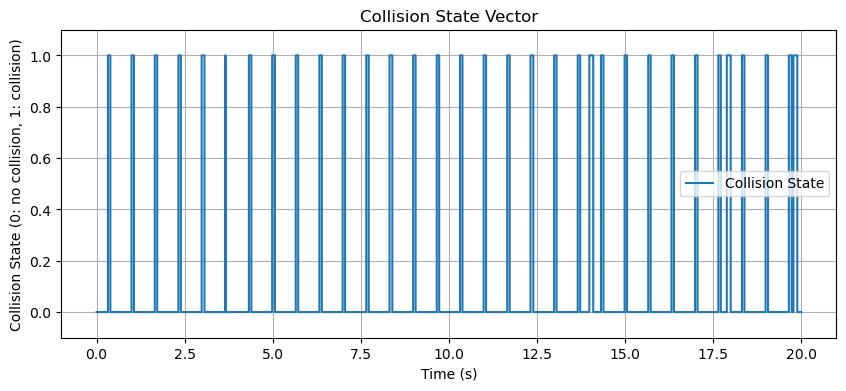

In [2]:
# --- Plot the Collision State Vector ---
plt.figure(figsize=(10, 4))
plt.step(t_uniform, collision_state, where='post', label='Collision State')
plt.xlabel('Time (s)')
plt.ylabel('Collision State (0: no collision, 1: collision)')
plt.title('Collision State Vector')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_feat = []


for i in range (1,46):
    # Initialize video capture
    cap = cv2.VideoCapture(f'/Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/video_only/video_only_ID_{i}.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS)
    print (f'./video_only/video_only_ID_{i}.mp4 is being processed...')
    # Blob Detector Parameters for the Ball
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 20      # Minimum area of the dot
    params.maxArea = 500     # Maximum area of the dot
    params.filterByCircularity = True
    params.minCircularity = 0.8  # Ensures dot is circular
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Store data for plotting and analysis
    time_data = []
    x_data = []
    y_data = []
    
    # Process the video frame-by-frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break
    
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect the Ball using blob detection
        keypoints = detector.detect(gray)
        if not keypoints:
            frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
            missing_time = frame_number / fps
            # print(f"Ball missing at time: {missing_time:.2f} sec")
        else:
            for kp in keypoints:
                x, y = int(kp.pt[0]), int(kp.pt[1])
                frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
                
                # Store coordinates and time for plotting
                time_data.append(frame_number / fps)
                x_data.append(x)
                y_data.append(y)
    
    cap.release()
    cv2.destroyAllWindows()
    
    # --- Compute extreme boundaries based on ball tracking data ---
    if x_data and y_data:
        detected_left_boundary = min(x_data)
        detected_right_boundary = max(x_data)
        detected_top_boundary = min(y_data)
        detected_bottom_boundary = max(y_data)
    
        print("Detected boundaries from ball tracking data:")
        print(f"Left boundary: {detected_left_boundary}")
        print(f"Right boundary: {detected_right_boundary}")
        print(f"Top boundary: {detected_top_boundary}")
        print(f"Bottom boundary: {detected_bottom_boundary}")
    else:
        print("No ball data was collected.")
        # Exit if no data was collected
        exit()
    
    # --- Detect Collision Timestamps using the detected boundaries ---
    # (This step still records collision events per frame)
    collision_threshold = 2  # pixels
    collision_timestamps = []
    for t, x, y in zip(time_data, x_data, y_data):
        if abs(x - detected_left_boundary) < collision_threshold:
            collision_timestamps.append(("Left", t))
        if abs(x - detected_right_boundary) < collision_threshold:
            collision_timestamps.append(("Right", t))
        if abs(y - detected_top_boundary) < collision_threshold:
            collision_timestamps.append(("Top", t))
        if abs(y - detected_bottom_boundary) < collision_threshold:
            collision_timestamps.append(("Bottom", t))
    
    # --- Create a Uniform Collision State Vector ---
    # We'll sample at 100 Hz (i.e., 100 samples per second of video)
    total_duration = time_data[-1]
    sample_rate = 100  # samples per second
    num_samples = int(total_duration * sample_rate)
    t_uniform = np.linspace(0, total_duration, num=num_samples)
    
    # Interpolate the tracked x and y positions to the uniform time vector
    x_uniform = np.interp(t_uniform, time_data, x_data)
    y_uniform = np.interp(t_uniform, time_data, y_data)
    
    # Create a binary collision vector:
    # A sample is marked as 1 if the ball's interpolated position is within the collision threshold
    collision_state = (
        (np.abs(x_uniform - detected_left_boundary) < collision_threshold) |
        (np.abs(x_uniform - detected_right_boundary) < collision_threshold) |
        # (np.abs(y_uniform - detected_top_boundary) < collision_threshold) |
        (np.abs(y_uniform - detected_bottom_boundary) < collision_threshold)
    ).astype(int)
    
    image_feat.append(collision_state)


./video_only/video_only_ID_1.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 65
Right boundary: 377
Top boundary: 124
Bottom boundary: 245
./video_only/video_only_ID_2.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 61
Right boundary: 381
Top boundary: 39
Bottom boundary: 244
./video_only/video_only_ID_3.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 58
Right boundary: 382
Top boundary: 138
Bottom boundary: 245
./video_only/video_only_ID_4.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 62
Right boundary: 382
Top boundary: 123
Bottom boundary: 245
./video_only/video_only_ID_5.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 64
Right boundary: 378
Top boundary: 103
Bottom boundary: 245
./video_only/video_only_ID_6.mp4 is being processed...
Detected boundaries from ball tracking data:
Left boundary: 6

In [3]:
print (len(image_feat))
print (len(image_feat[5]))
print (image_feat)

45
2000
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 1]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 1]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]),

In [4]:
import numpy as np

# Determine the maximum size along dimension 1
max_length = max(arr.shape[0] for arr in image_feat)

# Pad each array to match the maximum length
padded_image_feat = [np.pad(arr, (0, max_length - arr.shape[0]), mode='constant') for arr in image_feat]

# Convert the padded list to a 2D NumPy array
image_feat = np.vstack(padded_image_feat)

# Verify the shape
assert image_feat.shape == (45, max_length), "Reshape failed"

# Save to CSV for future use (kind of a checkpoint)
np.savetxt('image_features_extracted_openCV.csv', image_feat, delimiter=',', fmt='%d')

Plotting features for image features...


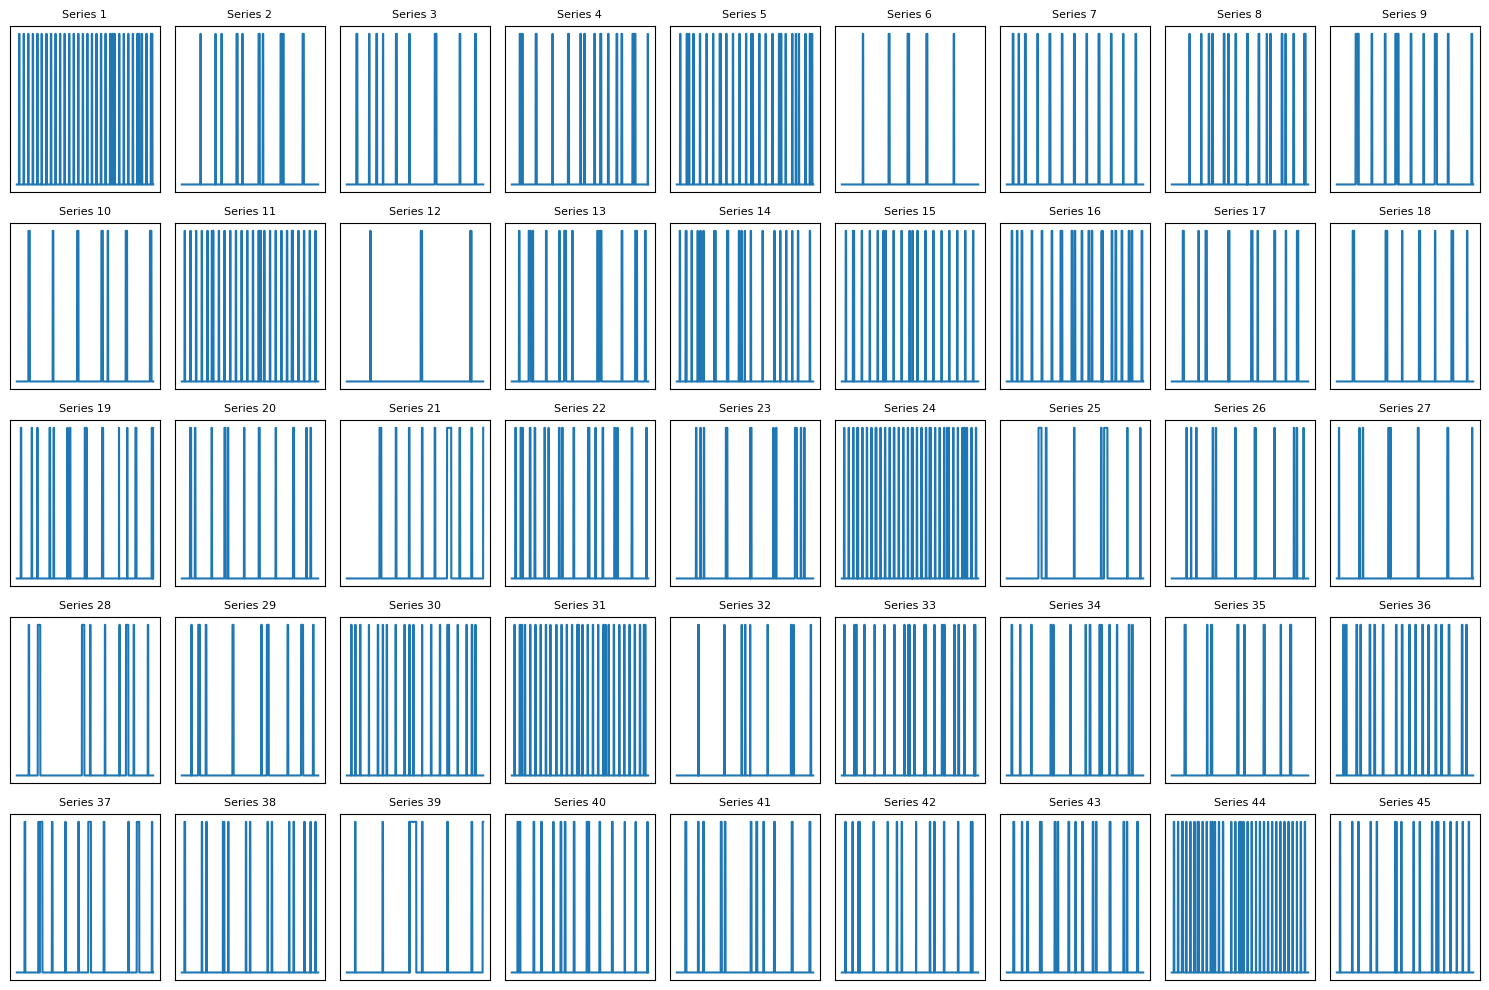

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print ("Plotting features for image features...")

# Number of rows and columns for the grid
rows = 5
cols = 9  # Total 45 series = 5 x 9

plt.figure(figsize=(15, 10))

for i in range(image_feat.shape[0]):
    plt.subplot(rows, cols, i + 1) 
    plt.plot(image_feat[i], label=f'Series {i + 1}')
    plt.title(f'Series {i + 1}', fontsize=8)
    plt.xticks([])  # Hide x-axis ticks for cleaner visualization
    plt.yticks([]) 
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
import librosa
import numpy as np
from scipy.signal import find_peaks, peak_widths
import os

def extract_binary_vector(audio_path, num_samples=2000, duration=20):
    """
    Extracts a binary feature vector for an audio file by detecting peaks
    in the onset envelope and marking an interval around each peak as 1.
    
    Parameters:
    - audio_path: Path to the audio file.
    - num_samples: Length of the binary vector (default 2000).
    - duration: Duration of the audio in seconds (default 20).
    
    Returns:
    - binary_vector: A binary (0/1) numpy array of length num_samples.
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    y_filtered = y
    
    # Compute onset envelope (energy function for percussive events)
    onset_env = librosa.onset.onset_strength(y=y_filtered, sr=sr)
    
    # Detect peaks in the onset envelope
    peaks, _ = find_peaks(onset_env, height=0.2)
    
    # Compute widths of the detected peaks (unpack 4 outputs)
    widths, _, left_ips, right_ips = peak_widths(onset_env, peaks, rel_height=0.5)
    
    # Initialize binary vector
    binary_vector = np.zeros(num_samples)
    # print (peaks)
    # For each detected peak, mark the interval as 1 in the binary vector
    for i in range(len(peaks)):
        # Convert the left and right positions (in onset envelope frame indices) to time (seconds)
        left_time = librosa.frames_to_time(left_ips[i], sr=sr)
        right_time = librosa.frames_to_time(right_ips[i], sr=sr)
        
        # Map times to indices in the binary vector
        left_index = int((left_time / duration) * num_samples)
        right_index = int((right_time / duration) * num_samples)
        # print (left_index)
        # Ensure indices are within bounds
        left_index = max(0, left_index)
        right_index = min(num_samples - 1, right_index)
        
        # Set the interval to 1
        binary_vector[left_index:right_index+1] = 1
        
    return binary_vector

# Parameters
num_samples = 2000   # Each audio file is represented as a vector of length 2000
total_files = 45     # Process 45 audio files
binary_features = np.zeros((total_files, num_samples), dtype=int)

# Process each audio file from audio_only_ID_1.wav to audio_only_ID_45.wav
for i in range(1, total_files + 1):
    audio_path = f'/Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_{i}.wav'
    binary_features[i-1] = extract_binary_vector(audio_path, num_samples=num_samples, duration=20)
    print(f"Processed: {audio_path}")

# Save the binary feature matrix to a CSV file
np.savetxt('audio_binary_features.csv', binary_features, delimiter=',', fmt='%d')
print("Binary feature extraction completed and saved as 'audio_binary_features.csv'.")
audio_features = binary_features

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_1.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_2.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_3.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_4.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_5.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_6.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_7.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_8.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_9.wav
Processed: /Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/dataset/audio_only/audio_only_ID_10.wav
Processed

Plotting features for audio features...


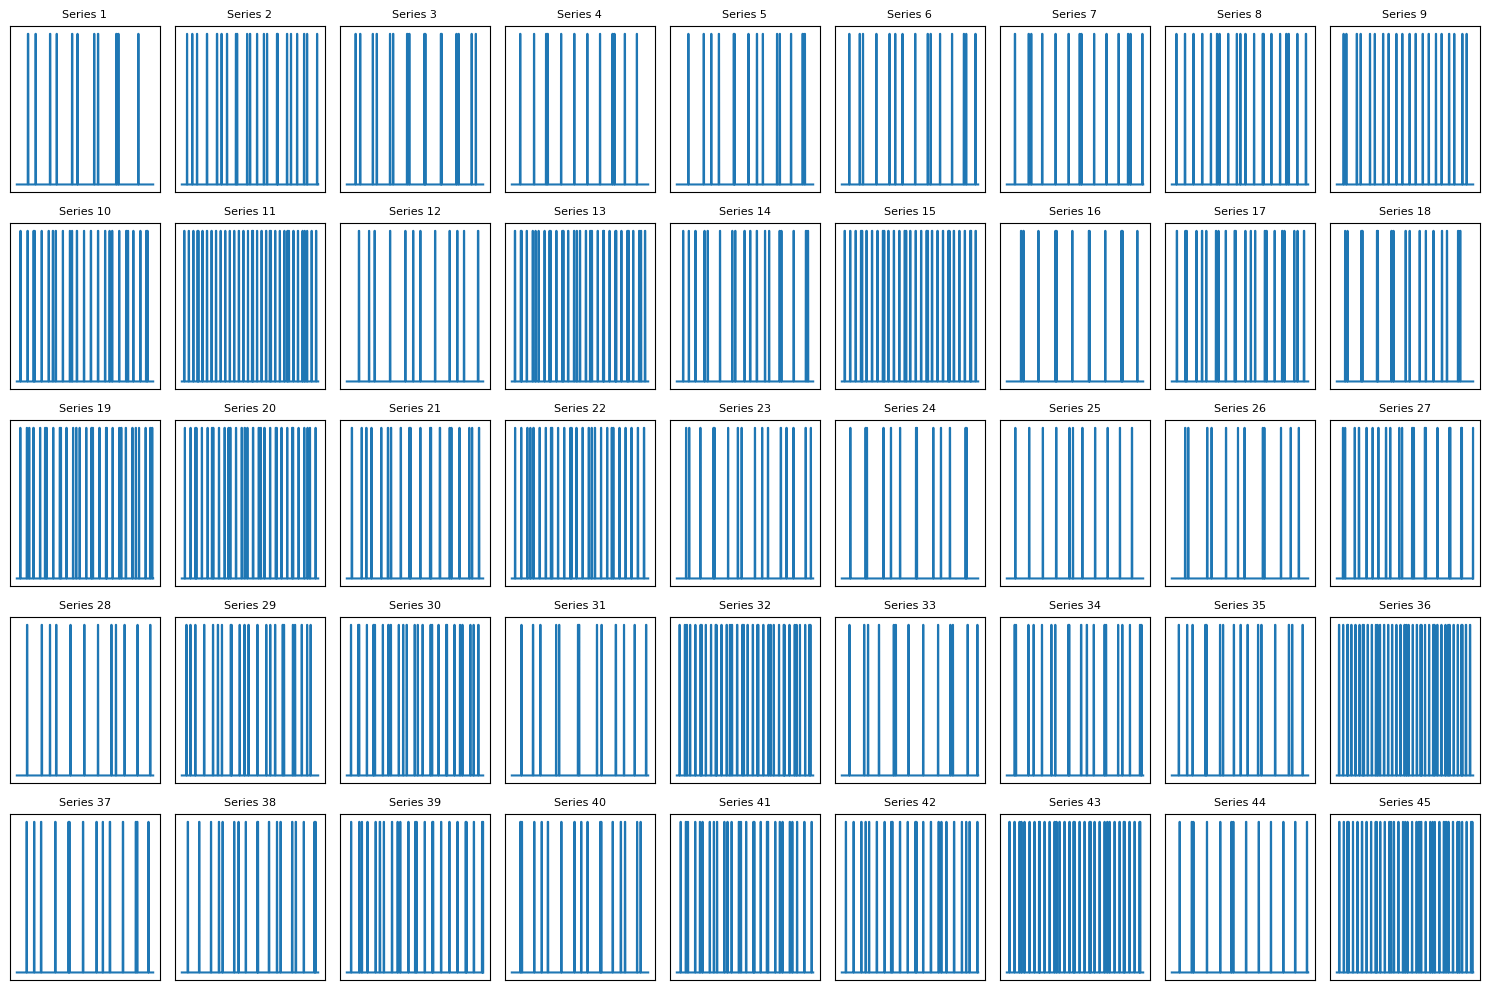

In [7]:
import matplotlib.pyplot as plt
import numpy as np
print ("Plotting features for audio features...")
# Number of rows and columns for the grid
rows = 5
cols = 9  # Total 45 series = 5 x 9

plt.figure(figsize=(15, 10))

for i in range(audio_features.shape[0]):
    plt.subplot(rows, cols, i + 1) 
    plt.plot(audio_features[i], label=f'Series {i + 1}')
    plt.title(f'Series {i + 1}', fontsize=8)
    plt.xticks([])  # Hide x-axis ticks for cleaner visualization
    plt.yticks([]) 
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np

# Update file paths as needed
image_features = pd.read_csv("/Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/image_features_extracted_openCV.csv")
audio_features = pd.read_csv("/Users/shivansh420/Desktop/MMDP-2_Dataset/Task-2/audio_binary_features.csv")

# Convert DataFrames to NumPy arrays
image_features = image_features.to_numpy()
audio_features = audio_features.to_numpy()

print("Image Features Shape:", image_features.shape)
print("Audio Features Shape:", audio_features.shape)

Image Features Shape: (44, 2000)
Audio Features Shape: (44, 2000)


Optimal Matching (Permutation):
Image Row 1 matches Audio Row 44 with Jaccard Similarity 0.0152
Image Row 2 matches Audio Row 39 with Jaccard Similarity 0.3312
Image Row 3 matches Audio Row 17 with Jaccard Similarity 0.3636
Image Row 4 matches Audio Row 18 with Jaccard Similarity 0.5314
Image Row 5 matches Audio Row 30 with Jaccard Similarity 0.2586
Image Row 6 matches Audio Row 13 with Jaccard Similarity 0.3533
Image Row 7 matches Audio Row 37 with Jaccard Similarity 0.3708
Image Row 8 matches Audio Row 43 with Jaccard Similarity 0.3030
Image Row 9 matches Audio Row 22 with Jaccard Similarity 0.1793
Image Row 10 matches Audio Row 19 with Jaccard Similarity 0.5000
Image Row 11 matches Audio Row 23 with Jaccard Similarity 0.2022
Image Row 12 matches Audio Row 5 with Jaccard Similarity 0.3059
Image Row 13 matches Audio Row 12 with Jaccard Similarity 0.3644
Image Row 14 matches Audio Row 29 with Jaccard Similarity 0.4657
Image Row 15 matches Audio Row 1 with Jaccard Similarity 0.4632
Imag

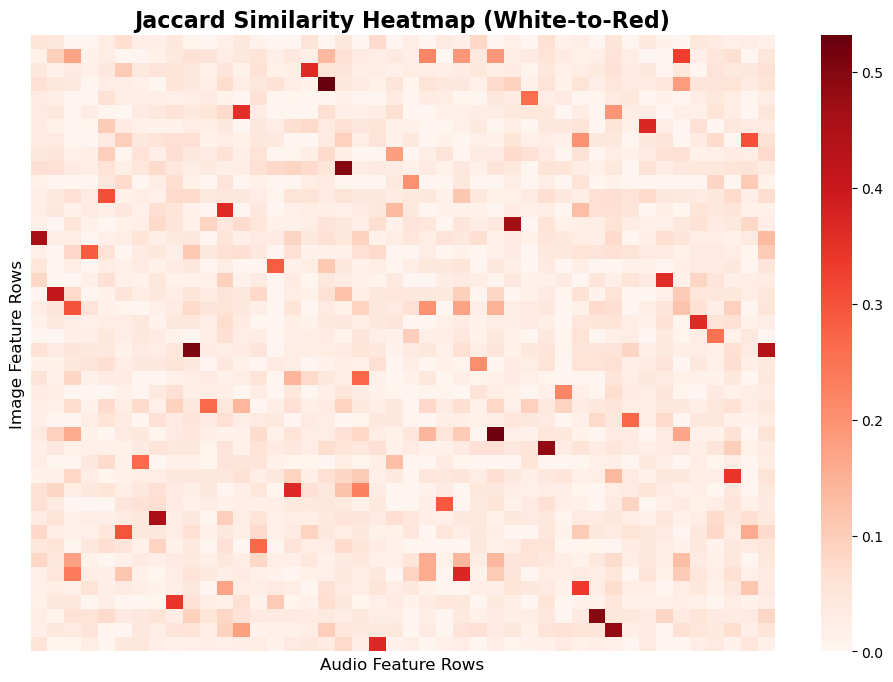

In [17]:
from sklearn.metrics import jaccard_score
from scipy.optimize import linear_sum_assignment
import seaborn as sns

jaccard_similarities = np.zeros((image_features.shape[0], audio_features.shape[0]))

for i in range(image_features.shape[0]):
    for j in range(audio_features.shape[0]):
        jaccard_similarities[i, j] = jaccard_score(image_features[i], audio_features[j])

# Ensure matching is a permutation using Hungarian Algorithm
row_indices, col_indices = linear_sum_assignment(-jaccard_similarities)  # Maximize similarity

print("Optimal Matching (Permutation):")
for i, j in zip(row_indices, col_indices):
    print(f"Image Row {i+1} matches Audio Row {j+1} with Jaccard Similarity {jaccard_similarities[i, j]:.4f}")

# Heatmap Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    jaccard_similarities, 
    cmap='Reds',          # White-to-Red gradient
    cbar=True,            # Add color bar
    xticklabels=False,    # Cleaner visualization
    yticklabels=False
)

plt.title('Jaccard Similarity Heatmap (White-to-Red)', fontsize=16, fontweight='bold')
plt.xlabel('Audio Feature Rows', fontsize=12)
plt.ylabel('Image Feature Rows', fontsize=12)
plt.show()